# Generate adversarial examples using ResNet

## Install the necessary packages

In [1]:
!pip install torch==2.0.1 torchvision==0.15.2 pillow==9.5.0 matplotlib==3.7.1

## Import packages

In [2]:
import torch
import torchvision.models as models
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F

# Make Python aware of the library by expanding the path search list
import sys
sys.path.append("..")
from adv_gen.generator import AdversarialExampleGenerator

## Load the ResNet model

It is possible to use another model without changing the code below.

In [3]:
model = models.resnet34(weights=models.ResNet34_Weights)
model.eval(); # Set the model to inference mode (to deactivate dropout, etc.)

/home/kira/anaconda3/envs/adversarial-example-generator/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Define helper functions

The functions below help visualize the adversarial examples.

In [4]:
def get_classes_names() -> dict[int, str]:
    """
        Returns a dictionary mapping class indices to class names.
    """
    
    with open("imagenet_classes.txt") as f:
        # Just keep the first word of every class description
        classes = [line.strip().split(',')[0] for line in f.readlines()]
    return dict(enumerate(classes))

In [5]:
def image_to_tensor(img: Image.Image) -> torch.Tensor:
    transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]
    )

    # Add the batch dimension
    # （C, H, W) --> (1, C, H, W)
    return transform(img).unsqueeze(0)

def tensor_to_image(tensor: torch.Tensor) -> Image.Image:
    transform = transforms.Compose(
        [
            # De-normalize
            transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
            transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        ]
    )

    # Remove the batch dimension
    # (1, C, H, W) --> (C, H, W)
    image = transform(tensor.squeeze(0))
    image = image.clamp(0, 1)
    # (C, H, W) --> (H, W, C)
    image = image.permute(1, 2, 0)
    return image.detach().numpy()


def get_input_tensor(img_path: str) -> torch.Tensor:
    img = Image.open(img_path)
    # Applies normalization and scaling. Returns a tensor of shape (C, H, W)
    img_tensor = image_to_tensor(img)
    return img_tensor

def show_images(imgs: dict) -> None:
    # Create a figure to display the images
    fig = plt.figure(figsize=(20, 20))
    # Get the number of images
    num_images = len(imgs)
    # Loop through the images and add them to the figure
    for i in range(num_images):
        # Add a subplot for each image
        ax = fig.add_subplot(1, num_images, i + 1)
        # Get the image at the current index
        img_data = imgs[i]
        # Show the image on the subplot
        ax.imshow(img_data["image"])
        # Hide the axes
        ax.axis("off")
        # Add the title
        ax.set_title(img_data["title"])
        # Add text on top of the image.
        ax.text(
            0.5,
            -0.15,
            img_data["classification"],
            size=14,
            ha="center",
            transform=ax.transAxes,
            wrap=True,
        )
    
    plt.show()


## Generate the adversarial example

We use a random target class, but it can be set below to any number between 0 and 999.
If the target class is is unrelated to the original class, you may need to increase the number of steps.

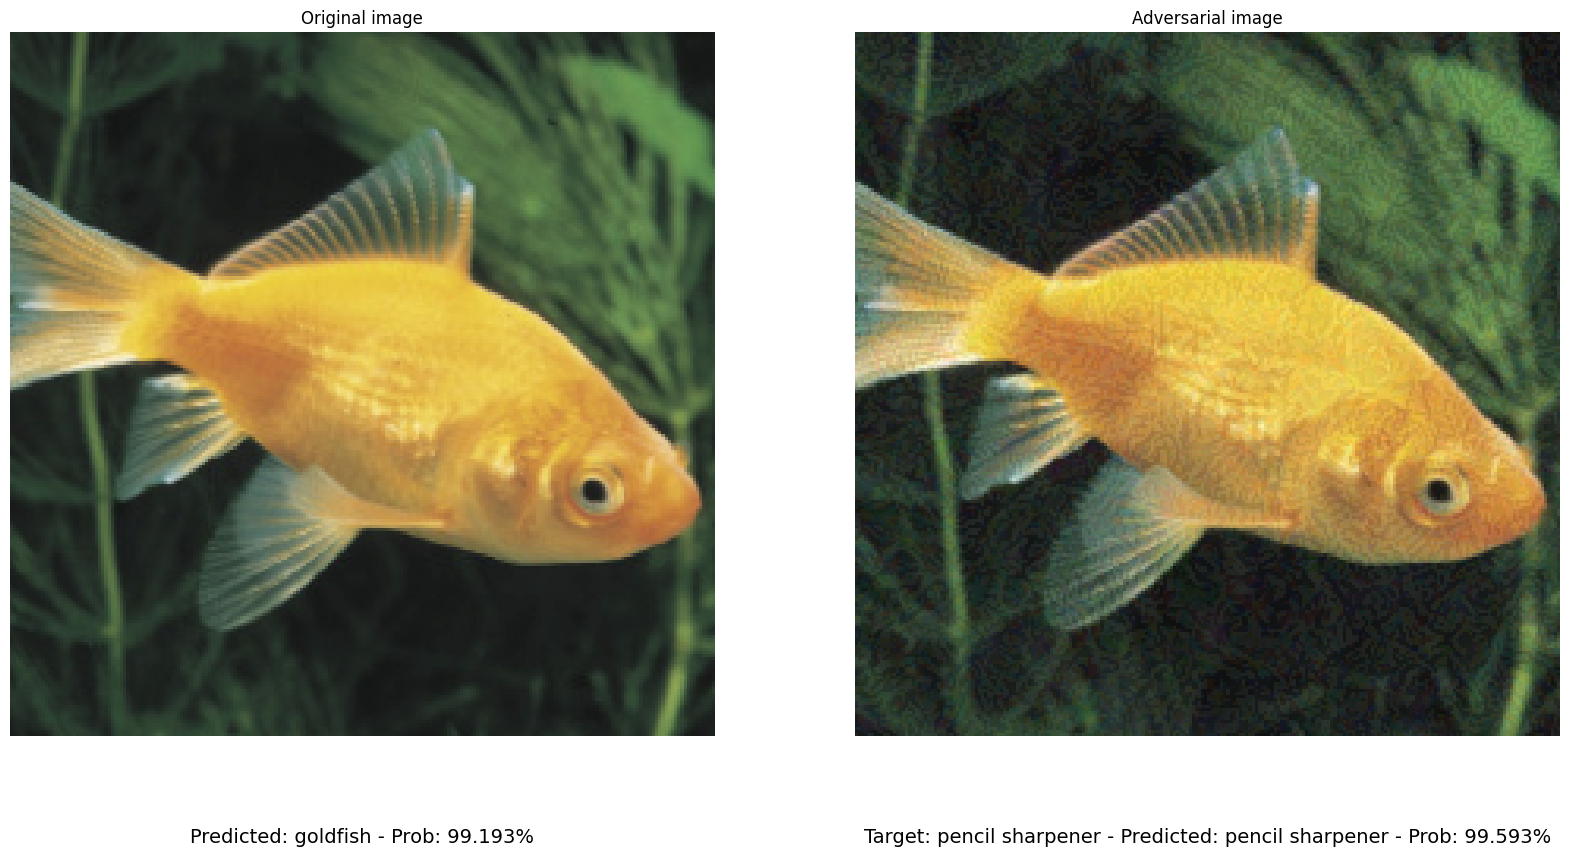

In [7]:
generator = AdversarialExampleGenerator(model)

# Load the original image
original_example = get_input_tensor("goldfish.jpeg")

# Define the target class randomly
target_class = random.randint(0, 999)

# Generate the adversarial example using the defined number of steps.
adversarial_example = generator.generate(original_example, target_class, num_steps=5)

# Get the model's prediction for the original image and the adversarial example.
original_output = model(original_example)
adversarial_output = model(adversarial_example)

# Gather the data to display
classes_names = get_classes_names()
predicted_class_original_name = classes_names[torch.max(original_output.data, 1)[1][0].item()]
predicted_class_adversarial_name = classes_names[torch.max(adversarial_output.data, 1)[1][0].item()]

predicted_class_original_prob = round(torch.max(F.softmax(original_output.data, dim=1)[0]).item() * 100, 3)
predicted_class_adversarial_prob = round(torch.max(F.softmax(adversarial_output.data, dim=1)[0]).item() * 100, 3)

data_to_display = [
    {
        "image": tensor_to_image(original_example),
        "title": "Original image",
        "classification": f"Predicted: {predicted_class_original_name} - Prob: {predicted_class_original_prob}%",
    },
    {
        "image": tensor_to_image(adversarial_example),
        "title": "Adversarial image",
        "classification": f"Target: {classes_names[target_class]} - Predicted: {predicted_class_adversarial_name} - Prob: {predicted_class_adversarial_prob}%",
    },
]

show_images(data_to_display)